In [2]:
import pickle
import numpy as np
from scipy import sparse
import pandas as pd
import seaborn as sns
sns.set() ## set up style
import uuid
import time
import datetime
import matplotlib.pyplot as plt
#solved chinese display in matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
# rcParams["font.family"] = "DFKai-SB"
rcParams['axes.unicode_minus'] = False
from tqdm import tqdm_notebook,tnrange
# from tqdm.autonotebook import tqdm
# tqdm.pandas()

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from qhoptim.pyt import QHM, QHAdam
from BuildDataset import Tripletdataset
from Model import Encoder,Decoder,EncoderOneLayer,DecoderOneLayer

import visdom
vis=visdom.Visdom()

industry=['金融業', 'IC製造', 'IC設計', '電子零件元件', '電腦系統業', '石油及天然氣', '手機', '面板業', '太陽能',
       '板鋼', '被動元件', '車輛整車', '非鐵金屬', '流通業', '地產', '通訊設備', '遊戲產業', '印刷電路板相關',
       '貴金屬', '機械', '運輸事業', '電子通路', 'IC封裝測試', 'LED', '通訊服務', '消費性電子產品', '化學工業',
       '醫藥產業', '軟體業', '週邊產品', '石化業', '旅館、餐飲', '汽機車零組件', '設備儀器廠商', '條鋼', '造紙業',
       '水泥', '橡膠工業', '傳產其他', '數位相機', '顯示器', '不鏽鋼', '農林漁牧', '服務業', 'Internet相關',
       '營造工程', '休閒娛樂', '紡織中游', '生物科技', '家電', '光碟片', '建材', '成衣', '電力', '運動產業',
       '線材、盤元', '化纖原料', '其他公用事業', '大宗物資', '家居用品', '手機零組件', '食品加工', '電力設備',
       '航天軍工', '分離式元件', '電子其他', '面板零組件', '飲料相關', '電線電纜', '封測服務與材料', '礦石開採',
       '光通訊', '傳播事業', '輔助與彌補用醫材', '時尚產業', '基礎建設營運', '電聲產品', '水資源', '醫療器材通路',
       '合金鋼', '文化創意產業', '車用金屬成型', '穿戴式裝置', '其他醫療器材', '汽車內裝', '車用電子',
       '診斷與監測用醫材', '傳輸介面', '電子化工材料', '電池材料相關', '資產股', '醫療管理服務', '體外診斷用醫材', '煤',
       '射頻前端晶片', '控股公司', '無店舖販售', '手術與治療用醫材', '金屬礦採選', '生物辨識相關']

In [3]:
## Load industry dictionary
with open("D:4.AutoencoderForArticle.Mid-Industry/dict_guid_sparsebow_20000_single.v05.p","rb") as f:
    dict_guid_sparsebow_single= pickle.load(f)
with open("D:4.AutoencoderForArticle.Mid-Industry/dict_singleindustry_guid.p","rb") as f:
    dict_singleindustry_guid= pickle.load(f)

In [4]:
## Industry with news more than 100 pics
industry_partial=industry[:80]

In [5]:
len(industry_partial)

80

#### Configuration for split dataset to triain and test

In [6]:
Split=8/18
Split_train_test=8/10

#### Sample part of Dataset

In [7]:
dict_split_industry_guid={ ind:np.random.choice(dict_singleindustry_guid[ind],
                                                     size=int(Split*len(dict_singleindustry_guid[ind])),
                                                     replace=False) for ind in industry_partial}
print("Total Vip News:",sum([len(dict_split_industry_guid[k]) for k in dict_split_industry_guid ]))

Total Vip News: 83128


In [8]:
dict_train_industry_guid={ind:dict_split_industry_guid[ind][:int(Split_train_test*len(dict_split_industry_guid[ind]))]
                          for ind in dict_split_industry_guid}
dict_test_industry_guid={ind:dict_split_industry_guid[ind][int(Split_train_test*len(dict_split_industry_guid[ind])):]
                          for ind in dict_split_industry_guid}
with open("dict_train_industry_guid.p","wb") as f:
    pickle.dump(dict_train_industry_guid,f)
with open("dict_test_industry_guid.p","wb") as f:
    pickle.dump(dict_test_industry_guid,f)
print("Train Vip News:",sum([len(dict_train_industry_guid[k]) for k in dict_train_industry_guid ]))
print("Test Vip News :",sum([len(dict_test_industry_guid[k]) for k in dict_test_industry_guid ]))

Train Vip News: 66473
Test Vip News : 16655


In [121]:
dict_str_list=dict_split_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         9444
IC製造        4450
IC設計        4249
電子零件元件      3909
電腦系統業       3043
石油及天然氣      2880
手機          2852
面板業         2572
太陽能         2425
板鋼          2208
被動元件        2190
車輛整車        2175
非鐵金屬        2149
流通業         2053
地產          1856
通訊設備        1824
遊戲產業        1788
印刷電路板相關     1732
貴金屬         1565
機械          1437
運輸事業        1436
電子通路        1344
IC封裝測試      1207
LED         1064
通訊服務        1063
消費性電子產品      943
化學工業         931
醫藥產業         894
軟體業          892
週邊產品         892
            ... 
光碟片          304
建材           263
成衣           260
電力           249
運動產業         243
線材、盤元        241
化纖原料         234
其他公用事業       224
大宗物資         220
家居用品         210
手機零組件        185
食品加工         172
電力設備         164
航天軍工         156
分離式元件        153
電子其他         144
面板零組件        136
飲料相關         124
電線電纜         121
封測服務與材料      120
礦石開採         104
光通訊           84
傳播事業          81
時尚產業          80
輔助與彌補用醫材      80
基礎建設營運        72
電聲產品          69
水資源           

In [9]:
dict_str_list=dict_train_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         4958
IC製造        2336
IC設計        2230
電子零件元件      2052
電腦系統業       1597
石油及天然氣      1512
手機          1497
面板業         1350
太陽能         1273
板鋼          1159
被動元件        1150
車輛整車        1141
非鐵金屬        1128
流通業         1078
地產           974
通訊設備         957
遊戲產業         938
印刷電路板相關      909
貴金屬          821
機械           754
運輸事業         753
電子通路         705
IC封裝測試       633
LED          558
通訊服務         557
消費性電子產品      494
化學工業         488
醫藥產業         469
軟體業          468
週邊產品         468
            ... 
光碟片          159
建材           137
成衣           136
電力           130
運動產業         127
線材、盤元        126
化纖原料         123
其他公用事業       117
大宗物資         115
家居用品         110
手機零組件         97
食品加工          90
電力設備          86
航天軍工          81
分離式元件         80
電子其他          75
面板零組件         71
飲料相關          65
電線電纜          63
封測服務與材料       62
礦石開採          54
光通訊           44
傳播事業          42
時尚產業          42
輔助與彌補用醫材      42
基礎建設營運        37
電聲產品          36
水資源           

In [10]:
dict_str_list=dict_test_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         2125
IC製造        1002
IC設計         957
電子零件元件       880
電腦系統業        685
石油及天然氣       648
手機           642
面板業          579
太陽能          546
板鋼           497
被動元件         493
車輛整車         490
非鐵金屬         484
流通業          462
地產           418
通訊設備         411
遊戲產業         403
印刷電路板相關      390
貴金屬          353
機械           324
運輸事業         324
電子通路         303
IC封裝測試       272
通訊服務         240
LED          240
消費性電子產品      213
化學工業         210
醫藥產業         202
軟體業          201
週邊產品         201
            ... 
光碟片           69
建材            60
成衣            59
電力            57
線材、盤元         55
運動產業          55
化纖原料          53
其他公用事業        51
大宗物資          50
家居用品          48
手機零組件         42
食品加工          39
電力設備          37
航天軍工          36
分離式元件         35
電子其他          33
面板零組件         31
封測服務與材料       28
電線電纜          28
飲料相關          28
礦石開採          24
光通訊           19
傳播事業          19
時尚產業          18
輔助與彌補用醫材      18
基礎建設營運        17
電聲產品          16
水資源           

#### Configure to train

In [9]:
EP_start=0
Epochs=3000
P=3
K=6
PK=P*K
inputDim=20000
repzDim=100
alpha=2
size=(K-1)*(PK-K)
PK*(K-1)*(PK-K)

1080

#### Dataset  & Model & Criterion & Optimizer Instantiation

In [10]:
###########################################################
##Dataset
dataset=Tripletdataset(industry_partial,
                       dict_train_industry_guid,
                       dict_guid_sparsebow_single,
                       P=P,K=K,
                      )
testset=Tripletdataset(industry_partial,
                       dict_test_industry_guid,
                       dict_guid_sparsebow_single,
                       P=P,K=K,
                      )
##########################################################
##model
modelEncoder = EncoderOneLayer(inputDim,repzDim).to(device)
# modelEncoder.eval()
modelDecoder = DecoderOneLayer(repzDim,inputDim).to(device)
# modelEncoder.eval()
############################################################
##criterion
# def criterionTriOrig(h0,h1,h2,reduction="mean"):
#     h01=(h0*h1).sum(dim=1)
#     h02=(h0*h2).sum(dim=1)
#     Lt=torch.log(1+torch.exp(h02-h01))
#     if reduction=="mean":
#         return {"Lt":Lt.mean()}
#     if reduction=="none": assert False,"this function not yet"
class TriLossOri():
    def __init__(self,reduction="mean",size=None):
        self.reduction=reduction.lower()
        self.size=size
    def forward(self,h0,h1,h2):
        h01=(h0*h1).sum(dim=1)
        h02=(h0*h2).sum(dim=1)
        Lt=torch.log(1+torch.exp(h02-h01))
        if self.reduction=="mean":
            assert self.size == None,"No need size"
            return {"Lt":Lt.mean()}
        if self.reduction=="max": 
            assert self.size ,"size isn't assigned yet"
            lossmax=torch.nn.functional.max_pool1d(Lt.view(1,1,Lt.size()[0])
                                                   ,kernel_size=self.size,stride=self.size).squeeze()
            assert lossmax.size()[0]==Lt.size()[0]/self.size,"Check if size is corrected"
            return {"Lt":lossmax.mean()}
    def __call__(self,h0,h1,h2):
        return self.forward(h0,h1,h2)      
def criterionTriModfy(h0,h1,h2,reduction="mean",alpha=1,beta=1):
    h01=(h0*h1).sum(dim=1)
    h02=(h0*h2).sum(dim=1)
    Lth01=alpha*torch.log(1+torch.exp(-h01))
    Lth02=-beta*torch.log( 1 - torch.sigmoid(h02)+(1e-6))
    Lt=Lth01+Lth02
    if reduction=="mean":
        return {"Lt":Lt.mean(),"Lth01":Lth01.mean(),"Lth02":Lth02.mean()}
    
# criterionTri=criterionTri    
criterionTri=TriLossOri(reduction="max",size=size)
criterionRC=torch.nn.BCELoss(reduction="mean") ## There is one called BCEWithLogitsLoss 

###############################################################
##optimizer
from torch.optim.lr_scheduler import CosineAnnealingLR
params=[{"params":modelEncoder.parameters()},
        {"params":modelDecoder.parameters()},]
# optimizerSgd=torch.optim.SGD([{"params":modelEncoder.parameters()},
#                            {"params":modelDecoder.parameters()},
#                            ],
#                           lr=0.001,
#                             )

# optimizer = QHM([{"params":modelEncoder.parameters()},
#                            {"params":modelDecoder.parameters()},
#                            ], lr=0.5, nu=0.7, momentum=0.999)

optimizer = QHAdam(params=params, lr=1e-3, nus=(0.7, 1.0), betas=(0.995, 0.999))

# optimizer=torch.optim.Adam([{"params":modelEncoder.parameters()},
#                            {"params":modelDecoder.parameters()},
#                            ])
LearningRS=False
# scheduler=CosineAnnealingLR(optimizer,T_max=200,eta_min=0.0000005)
###############################################################

In [13]:
for i, (batchData,batchTest) in enumerate(zip(dataset,testset)):
    verif=batchData["batch_anchor"]
    break

In [21]:
verif[120:180].sum(1)

array([190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190,
       190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190,
       190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190,
       190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190,
       190, 190, 190, 190, 190, 190, 190, 190])

In [105]:
modelEncoder

EncoderOneLayer(
  (linear1): Linear(in_features=20000, out_features=100, bias=True)
  (sigmoid): Sigmoid()
)

In [106]:
modelDecoder

DecoderOneLayer(
  (linear1): Linear(in_features=100, out_features=20000, bias=True)
  (sigmoid): Sigmoid()
)

In [107]:
def opts(**kwords):
    opts={"markers":False,"xlabel":"epochs","title":"Total Loss","width":1200,"heigh":300,"xtickmax":100}
    for k in kwords:
        opts[k]=kwords[k]
    return opts

In [108]:
trainingloss={"loss":[],"lossRA":[],"lossRP":[],"lossRN":[],"lossT":[],"lossTh01":[],"lossTh02":[]}
testloss={"loss":[],"lossRA":[],"lossRP":[],"lossRN":[],"lossT":[],"lossTh01":[],"lossTh02":[]}

#### Train

In [109]:
s_start=datetime.datetime.now()
s_total=time.time()
print(s_start)
for ep in tnrange(Epochs):
    if LearningRS==True : scheduler.step()
    s_epoch=time.time()
    s_epochWithAllstep=time.time()
    ep+=1+EP_start
    dataset.shuffle()
    for i, (batchData,batchTest) in enumerate(zip(dataset,testset)):
        
        s_batch=time.time()
        
        optimizer.zero_grad()
        
        s_prepare=time.time()
        ## Train 
        ## array int8 to float 32
        batchAnchor=batchData["batch_anchor"].astype(np.float32) 
        batchPositive=batchData["batch_positive"].astype(np.float32)
        batchNegative=batchData["batch_negative"].astype(np.float32)
        ## array  to tensor float 32
        batchAnchorTensor=torch.tensor(batchAnchor,dtype=torch.float32,device=device)
        batchPositiveTensor=torch.tensor(batchPositive,dtype=torch.float32,device=device)
        batchNegativeTensor=torch.tensor(batchNegative,dtype=torch.float32,device=device)
        
        e_prepare=time.time()
        
        s_inference=time.time()
        ## Inference
        #### encoding
        anchorRepz   = modelEncoder(batchAnchorTensor)
        positiceRepz = modelEncoder(batchPositiveTensor)
        negativeRepz = modelEncoder(batchNegativeTensor)
        #### decoding
        anchorRc   = modelDecoder(anchorRepz)
        positiveRc = modelDecoder(positiceRepz)
        negativeRc = modelDecoder(negativeRepz)
        
        with torch.no_grad():
            assert ((anchorRc >=0)*(anchorRc <=1)).all()
            assert ((batchAnchorTensor >=0)*(batchAnchorTensor <=1)).all()
            assert ((positiveRc >=0)*(positiveRc <=1)).all()
            assert ((batchPositiveTensor >=0)*(batchPositiveTensor <=1)).all()
            assert ((negativeRc >=0)*(negativeRc <=1)).all()
            assert ((batchNegativeTensor >=0)*(batchNegativeTensor <=1)).all()
            
        lossRA = criterionRC(anchorRc,batchAnchorTensor)
        lossRP = criterionRC(positiveRc,batchPositiveTensor)
        lossRN = criterionRC(negativeRc,batchNegativeTensor)
        
        lossT = criterionTri(anchorRepz,positiceRepz,negativeRepz,reduction="mean")
        
        loss = lossRA + lossRP + lossRN + alpha*(lossT["Lt"])
       
        e_inference = time.time()
        
        with torch.no_grad():
            assert loss!=torch.tensor(float('inf')).to (device)
        
        ## backward
        s_backward = time.time()
        loss.backward()
        e_backward = time.time()
        
        s_step=time.time()
        ## update
        optimizer.step()
        e_step=time.time()
        
        e_batch=time.time()
        ## record
#         with torch.no_grad():
#             trainingloss["loss"].append(loss.item())
#             trainingloss["lossRA"].append(lossRA.item())
#             trainingloss["lossRP"].append(lossRP.item())
#             trainingloss["lossRN"].append(lossRN.item())
#             trainingloss["lossT"].append(lossT.item())
    e_epoch=time.time()
    print("-------------------------------")
    print("epoch :",ep,"/",Epochs)
    print("epoch :",ep,"/",Epochs)
    print("loss  :",loss.item())
    print("lossRA:",lossRA.item(),",","lossRP:",lossRP.item(),",","lossRN:",lossRN.item())
    print("lossT :",lossT["Lt"].item())
    print("Batch-Time:",np.round(e_batch-s_batch,3),"s")
    print("Batch-PreTime",np.round(e_prepare-s_prepare,3),"s")
    print("Batch-InfTime:",np.round(e_inference-s_inference,3),"s")
    print("Batch-BackTime:",np.round(e_backward-s_backward,3),"s")
    print("Batch-UpdateTime:",np.round(e_step-s_step,3),"s")
    print("Epoch-Time",np.round(e_epoch-s_epoch,3),"s")
    
    s_trainRecord=time.time()
    ## Trainset record
    with torch.no_grad():
        trainingloss["loss"].append(loss.item())
        trainingloss["lossRA"].append(lossRA.item())
        trainingloss["lossRP"].append(lossRP.item())
        trainingloss["lossRN"].append(lossRN.item())
        trainingloss["lossT"].append(lossT["Lt"].item())
        try : trainingloss["lossTh01"].append(lossT["Lth02"].item())
        except KeyError : pass
        try : trainingloss["lossTh02"].append(lossT["Lth02"].item())
        except KeyError : pass
    e_trainRecord=time.time()
    s_testInference=time.time()
    ## Test Inference every epoch
    with torch.no_grad():
        ## Evaluation mode
        modelEncoder.eval()
        modelDecoder.eval()
        
        ## array int8 to float 32
        batchAnchor   = batchTest["batch_anchor"].astype(np.float32) 
        batchPositive = batchTest["batch_positive"].astype(np.float32)
        batchNegative = batchTest["batch_negative"].astype(np.float32)
        ## array  to tensor float 32
        batchAnchorTensor   = torch.tensor(batchAnchor,dtype=torch.float32,device=device)
        batchPositiveTensor = torch.tensor(batchPositive,dtype=torch.float32,device=device)
        batchNegativeTensor = torch.tensor(batchNegative,dtype=torch.float32,device=device)
        ## Inference
        #### encoding
        anchorRepz   = modelEncoder(batchAnchorTensor)
        positiceRepz = modelEncoder(batchPositiveTensor)
        negativeRepz = modelEncoder(batchNegativeTensor)
        #### decoding
        anchorRc   = modelDecoder(anchorRepz)
        positiveRc = modelDecoder(positiceRepz)
        negativeRc = modelDecoder(negativeRepz)
        #### loss
        lossRA_test = criterionRC(anchorRc,batchAnchorTensor)
        lossRP_test = criterionRC(positiveRc,batchPositiveTensor)
        lossRN_test = criterionRC(negativeRc,batchNegativeTensor)
        lossT_test  = criterionTri(anchorRepz,positiceRepz,negativeRepz,reduction="mean")
        loss_test   = lossRA_test+lossRP_test+lossRN_test+alpha*(lossT_test["Lt"])
        
        ## Train mode
        modelEncoder.train()
        modelDecoder.train()
        
    e_testInference=time.time()    
    s_testRecord=time.time()
    ### Testset Record
    testloss["loss"].append(loss_test.item())
    testloss["lossRA"].append(lossRA_test.item())
    testloss["lossRP"].append(lossRP_test.item())
    testloss["lossRN"].append(lossRN_test.item())
    testloss["lossT"].append(lossT_test["Lt"].item())
    try :testloss["lossTh01"].append(lossT_test["Lth01"].item())
    except KeyError :pass
    try :testloss["lossTh02"].append(lossT_test["Lth02"].item())
    except KeyError: pass 
    e_testRecord=time.time()
    s_plot=time.time()
    ##plot 
    win="train loss "
    vis.line(Y=[loss.item()]  ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossT"
    vis.line(Y=[lossT["Lt"].item()] ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossTh01"
    try : vis.line(Y=[lossT["Lth01"].item()],X=[ep],win=win,update="append",opts=opts(title=win))
    except KeyError : pass
    win="train lossTh02"
    try: vis.line(Y=[lossT["Lth02"].item()],X=[ep],win=win,update="append",opts=opts(title=win))    
    except KeyError :pass
    win="train lossRA"
    vis.line(Y=[lossRA.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossRP"
    vis.line(Y=[lossRP.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossRN"
    vis.line(Y=[lossRN.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test loss "
    vis.line(Y=[loss_test.item()]  ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossT"
    vis.line(Y=[lossT_test["Lt"].item()] ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossTh01"
    try :vis.line(Y=[lossT_test["Lth01"].item()],X=[ep],win=win,update="append",opts=opts(title=win))
    except KeyError : pass
    win="test lossTh02"
    try : vis.line(Y=[lossT_test["Lth02"].item()],X=[ep],win=win,update="append",opts=opts(title=win))
    except KeyError : pass
    win="test lossRA"
    vis.line(Y=[lossRA_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossRP"
    vis.line(Y=[lossRP_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossRN"
    vis.line(Y=[lossRN_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    
    e_plot=time.time()
    e_epochWithAllstep=time.time()

    print("Trainset record:",np.round(e_trainRecord-s_trainRecord,3),"s")
    print("Test Inference",np.round(e_testInference-s_testInference,3),"s")
    print("Testset Record:",np.round(e_testRecord-s_testRecord,3),"s")
    print("Visom Plot:",np.round(s_plot-s_plot,3),"s")    
    print("EpochWithAllstep",np.round(e_trainRecord-s_epochWithAllstep,3),"s")
e_total=time.time()
e_end=datetime.datetime.now()
print("START:",s_start)
print("END:",e_end)
print("Time:",np.round(e_total-s_total,3),"s")

2019-01-22 10:13:00.255123


-------------------------------
epoch : 1 / 2
epoch : 1 / 2
loss  : 3.0580568313598633
lossRA: 0.5434706807136536 , lossRP: 0.5513091683387756 , lossRN: 0.5443139672279358
lossT : 0.7094815373420715
Batch-Time: 0.16 s
Batch-PreTime 0.002 s
Batch-InfTime: 0.03 s
Batch-BackTime: 0.069 s
Batch-UpdateTime: 0.058 s
Epoch-Time 6.287 s
Trainset record: 0.0 s
Test Inference 0.032 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 6.322 s
-------------------------------
epoch : 2 / 2
epoch : 2 / 2
loss  : 2.451317310333252
lossRA: 0.3720017075538635 , lossRP: 0.36486393213272095 , lossRN: 0.3557412624359131
lossT : 0.6793552041053772
Batch-Time: 0.151 s
Batch-PreTime 0.003 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.061 s
Batch-UpdateTime: 0.058 s
Epoch-Time 6.238 s
Trainset record: 0.0 s
Test Inference 0.033 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 6.27 s

START: 2019-01-22 10:13:00.255123
END: 2019-01-22 10:13:13.085759
Time: 12.831 s


True

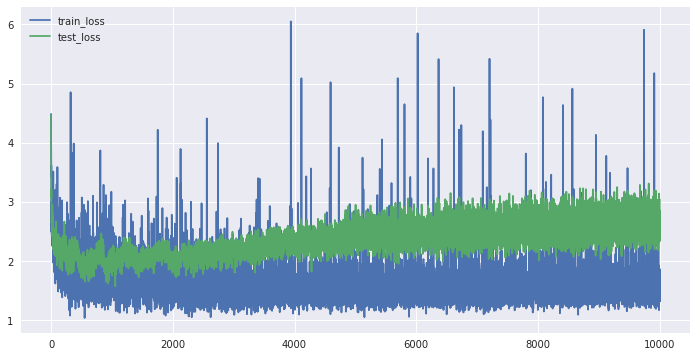

In [141]:
df=pd.DataFrame({"train_loss":trainingloss["loss"],"test_loss":testloss["loss"]})
df[["train_loss","test_loss"]].plot(figsize=(12,6))

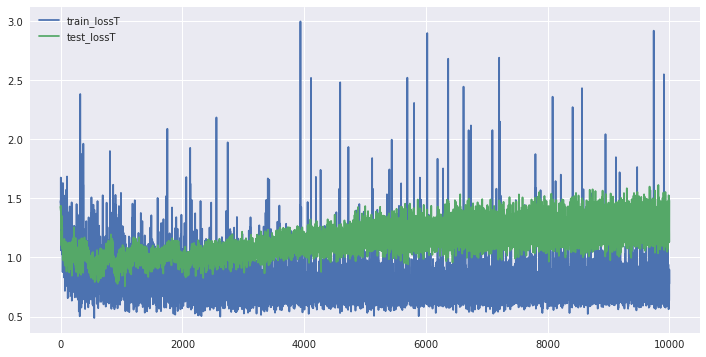

In [142]:
df=pd.DataFrame({"train_lossT":trainingloss["lossT"],"test_lossT":testloss["lossT"]})
df[["train_lossT","test_lossT"]].plot(figsize=(12,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabe78166a0>,
      dtype=object)

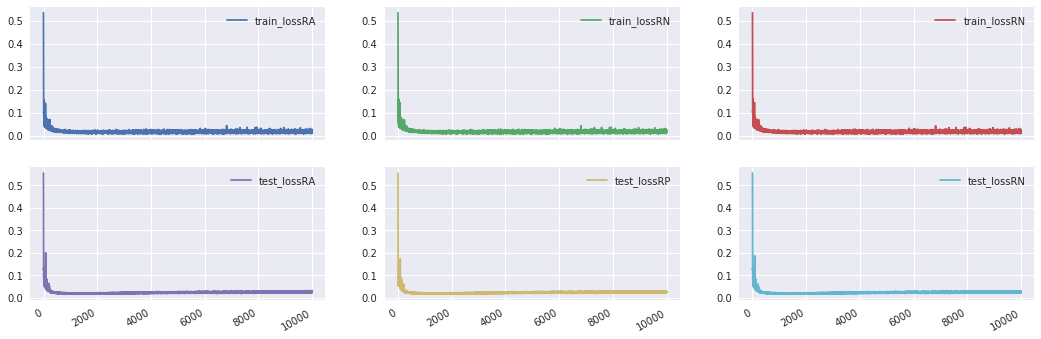

In [143]:
# df=pd.DataFrame(trainingloss)
df=pd.DataFrame({"train_lossRA":trainingloss["lossRA"],"test_lossRA":testloss["lossRA"],
                "train_lossRP":trainingloss["lossRP"],"test_lossRP":testloss["lossRP"],
                 "train_lossRN":trainingloss["lossRN"],"test_lossRN":testloss["lossRN"],
                })
# df[["train_lossT","test_lossT"]].plot(figsize=(12,6))
df[["train_lossRA","train_lossRN","train_lossRN","test_lossRA","test_lossRP","test_lossRN"]].plot(subplots=True,
                                                                                                   figsize=(18,6),layout=(2,3))

## Save model

In [144]:
EncoderStat="EncoderState.pt"
DecoderStat="DecoderState.pt"
torch.save(modelEncoder.state_dict(),EncoderStat) 
torch.save(modelDecoder.state_dict(),DecoderStat) 

## Save DATA

In [145]:
dfTrain=pd.DataFrame(trainingloss)
dfTest=pd.DataFrame(testloss)

In [146]:
trainLossPath="TrainLoss.p"
testLossPath="TestLoss.p"
dfTrain.to_pickle(trainLossPath)
dfTest.to_pickle(testLossPath)

### PLOT

In [67]:
# y=torch.tensor([1,float("inf"),1])
y=torch.tensor([5,3,2])
win="523"
vis.line(Y=y,X=[1,2,3],win=win,update="append",opts=opts())

'523'

In [144]:
win="test"
# opts={"markers":True,"xlabel":"epochs","title":"test Loss","width":1200,"heigh":300}
y=torch.randn(3)
win=vis.line(y,X=[1,2,3],win=win,opts=opts(),name="train-loss")

In [145]:
win="X"
# opts={"markers":True,"xlabel":"epochs","title":"X Loss","width":1200,"heigh":300}
y=torch.randn(3)
win=vis.line(y,X=[1,2,3],win=win,opts=opts(),name="train-loss")

In [146]:
vis